# Image Captioning with RNNs

In this exercise, you will implement vanilla recurrent neural networks (RNNs) to train a model that can generate natural language captions for images.

Models in this exercise are highly similar to very early works in neural-network based image captioning. If you are interested to learn more, check out these two papers:

1. [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)
2. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)

## Setup Code

Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You"ll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


 Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
["common", "a5_helper.py", "rnn_captioning.ipynb",  "rnn_captioning.py"]
```

In [ ]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a WI2022 folder and put all the files under A5 folder, then "WI2022/A5"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/HW4-Code/RNN'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['rnn_captioning.ipynb', 'a5_helper.py', 'rnn_captioning.py', '.DS_Store', 'helpers_module', '__pycache__']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from rnn_captioning.py!
```

as well as the last edit time for the file `rnn_captioning.py`.

In [ ]:
import os
import time
from rnn_captioning import hello_rnn_captioning


os.environ["TZ"] = "Asia/Tehran"
time.tzset()
hello_rnn_captioning()

rnn_path = os.path.join(GOOGLE_DRIVE_PATH, "rnn_captioning.py")
rnn_edit_ime = time.ctime(os.path.getmtime(rnn_path))
print("rnn_captioning.py last edited on %s" % rnn_edit_ime)

Hello from rnn_captioning.py!
rnn_captioning.py last edited on Wed Nov 29 12:25:51 2023


### Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import math
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

from helpers_module.grad import compute_numeric_gradient, rel_error
from helpers_module.utils import attention_visualizer, reset_seed

# for plotting
%matplotlib inline
plt.style.use("seaborn-v0_8")  # Prettier plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 24
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")


# Define some common variables for dtypes/devices.
# These can be keyword arguments while defining new tensors.
to_float = {"dtype": torch.float32, "device": DEVICE}
to_double = {"dtype": torch.float64, "device": DEVICE}

Good to go!


# COCO Captions

For this exercise we will use the 2014 release of the [COCO Captions dataset](http://cocodataset.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

We have preprocessed the data for you already and saved them into a serialized data file. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words. You can download the file named `coco.pt` (378MB) with the link below and run some useful stats.

You will later use RegNet-X 400MF model to extract features for the images. A few notes on the caption preprocessing:

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is saved in an entry named `vocab` (both `idx_to_token` and `token_to_idx`), and we use the function `decode_captions` from `a5_helper.py` to convert tensors of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [ ]:
import multiprocessing

# Set a few constants related to data loading.
IMAGE_SHAPE = (112, 112)
NUM_WORKERS = multiprocessing.cpu_count()

# Batch size used for full training runs:
BATCH_SIZE = 256

# Batch size used for overfitting sanity checks:
OVR_BATCH_SIZE = BATCH_SIZE // 8

# Batch size used for visualization:
VIS_BATCH_SIZE = 4

In [ ]:
from a5_helper import load_coco_captions

# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (IMAGE_SHAPE)
# "val_images" - resized validation images (IMAGE_SHAPE)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

if os.path.isfile("./datasets/coco.pt"):
    print("COCO data exists!")
else:
    print("downloading COCO dataset")
    !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt -P ./datasets/

# load COCO data from coco.pt, loaf_COCO is implemented in a5_helper.py
data_dict = load_coco_captions(path="./datasets/coco.pt")

num_train = data_dict["train_images"].size(0)
num_val = data_dict["val_images"].size(0)

# declare variables for special tokens
NULL_index = data_dict["vocab"]["token_to_idx"]["<NULL>"]
START_index = data_dict["vocab"]["token_to_idx"]["<START>"]
END_index = data_dict["vocab"]["token_to_idx"]["<END>"]
UNK_index = data_dict["vocab"]["token_to_idx"]["<UNK>"]

downloading COCO dataset
--2024-12-05 17:11:54--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘./datasets/coco.pt’

coco.pt             100%[===================>] 378.21M  44.4MB/s    in 8.7s    

2024-12-05 17:12:03 (43.4 MB/s) - ‘./datasets/coco.pt’ saved [396583632/396583632]



/content/drive/MyDrive/Colab Notebooks/HW4-Code/RNN/a5_helper.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(path)


train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Size([500, 3, 112, 112])
Validation caption tokens shape:  torch.Size([500, 17])
total number of caption tokens:  864
mappings (list) from index to caption token:  ['<NULL>', '<START>', '<END>', '<UNK>', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man', 'to', 'sitting', 'two', 'an', 'standing', 'people', 'are', 'at', 'next', 'white', 'woman', 'table', 'that', 'street', 'holding', 'some', 'person', 'down', 'large', 'top', 'group', 'tennis', 'field', 'it', 'plate', 'up', 'small', 'r

## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function.
You can check its implementation in `a5_helper.py`!

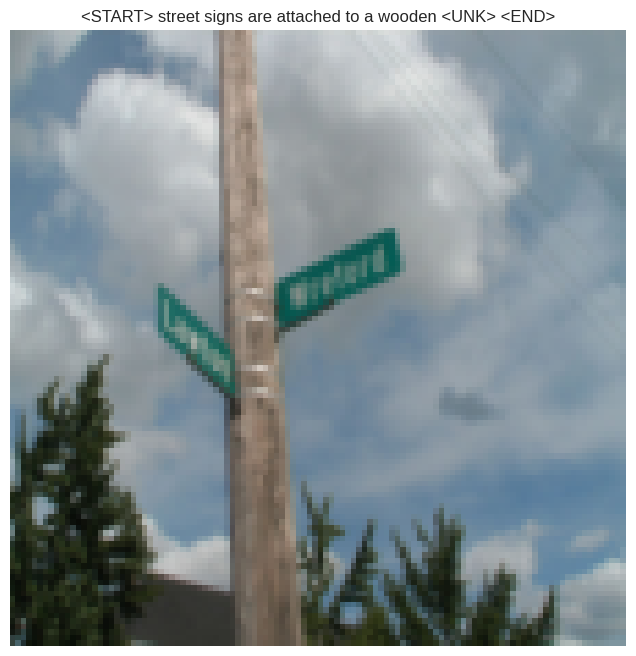

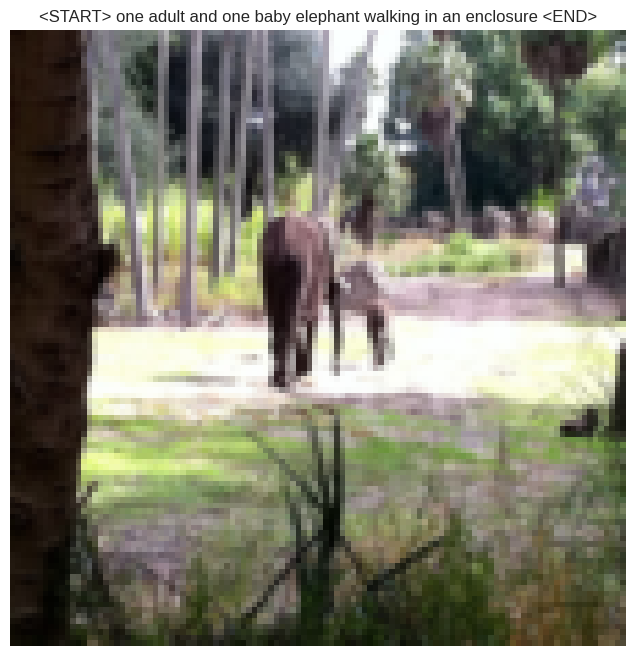

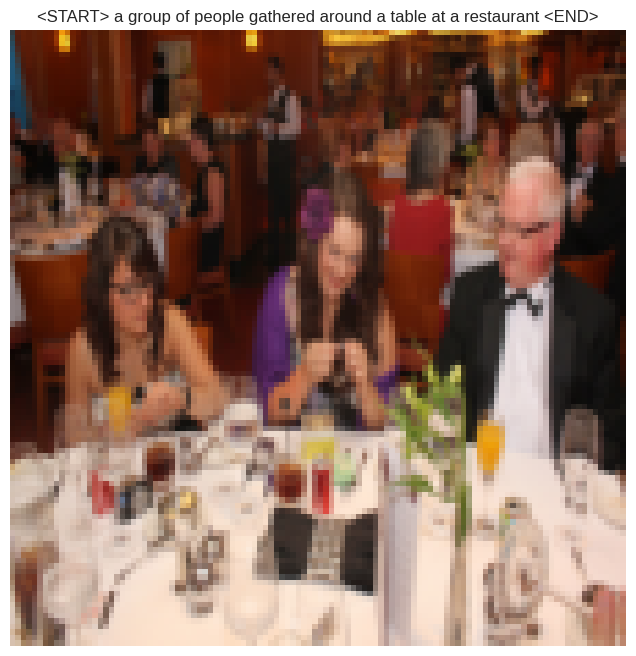

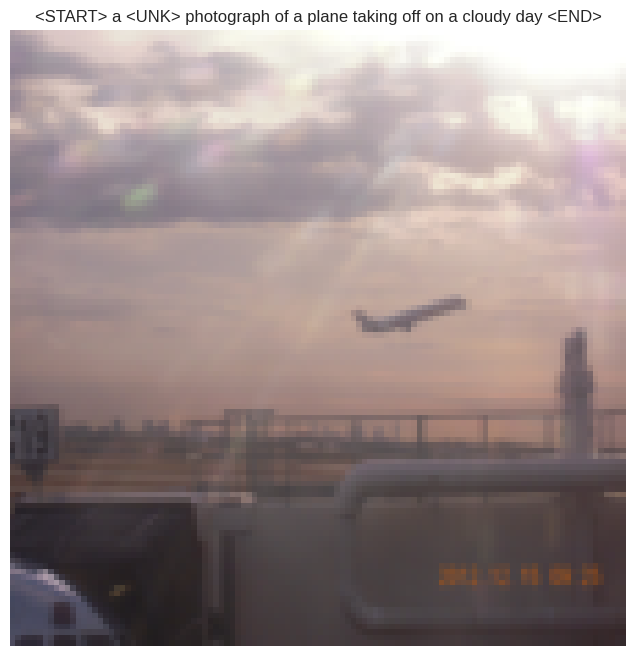

In [ ]:
from a5_helper import decode_captions


# Sample a minibatch and show the reshaped 112x112 images and captions
sample_idx = torch.randint(0, num_train, (VIS_BATCH_SIZE, ))
sample_images = data_dict["train_images"][sample_idx]
sample_captions = data_dict["train_captions"][sample_idx]
for i in range(VIS_BATCH_SIZE):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis("off")
    caption_str = decode_captions(
        sample_captions[i], data_dict["vocab"]["idx_to_token"]
    )
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use Recurrent Neural Network (RNN) language models for image captioning. We will cover the vanilla RNN model.

## Vanilla RNN: step forward

First implement the `rnn_step_forward` for a single timestep of a vanilla recurrent neural network.
Run the following to check your implementation. You should see errors on the order of `1e-8` or less.

In [ ]:
from rnn_captioning import rnn_step_forward

N, D, H = 3, 10, 4

x = torch.linspace(-0.4, 0.7, steps=N * D, **to_double).view(N, D)
prev_h = torch.linspace(-0.2, 0.5, steps=N * H, **to_double).view(N, H)
Wx = torch.linspace(-0.1, 0.9, steps=D * H, **to_double).view(D, H)
Wh = torch.linspace(-0.3, 0.7, steps=H * H, **to_double).view(H, H)
b = torch.linspace(-0.2, 0.4, steps=H, **to_double)


next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = torch.tensor(
    [
        [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
        [0.66854692, 0.79562378, 0.87755553, 0.92795967],
        [0.97934501, 0.99144213, 0.99646691, 0.99854353],
    ],
    **to_double
)

print("next_h error: ", rel_error(expected_next_h, next_h))

next_h error:  2.3200594408551194e-09


## Vanilla RNN: step backward
Then implement the `rnn_step_backward` for a single timestep of a vanilla recurrent neural network. Run the following to numerically gradient check your implementation. You should see errors on the order of `1e-8` or less.

In [ ]:
from rnn_captioning import rnn_step_backward
reset_seed(0)

N, D, H = 4, 5, 6
x = torch.randn(N, D, **to_double)
h = torch.randn(N, H, **to_double)
Wx = torch.randn(D, H, **to_double)
Wh = torch.randn(H, H, **to_double)
b = torch.randn(H, **to_double)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = torch.randn(*out.shape, **to_double)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dnext_h)
dprev_h_num = compute_numeric_gradient(fh, h, dnext_h)
dWx_num = compute_numeric_gradient(fWx, Wx, dnext_h)
dWh_num = compute_numeric_gradient(fWh, Wh, dnext_h)
db_num = compute_numeric_gradient(fb, b, dnext_h)

# YOUR_TURN: Implement rnn_step_backward
dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print("dx error: ", rel_error(dx_num, dx))
print("dprev_h error: ", rel_error(dprev_h_num, dprev_h))
print("dWx error: ", rel_error(dWx_num, dWx))
print("dWh error: ", rel_error(dWh_num, dWh))
print("db error: ", rel_error(db_num, db))

dx error:  3.530076341460208e-10
dprev_h error:  9.43543399128435e-10
dWx error:  2.2833809900403995e-10
dWh error:  2.45001015381931e-10
db error:  1.3316462459873777e-10


## Vanilla RNN: forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data. First implement `rnn_forward` by making calls to the `rnn_step_forward` function that you defined earlier.

Run the following to check your implementation. You should see errors on the order of `1e-6` or less.



In [ ]:
from rnn_captioning import rnn_forward


N, T, D, H = 2, 3, 4, 5

x = torch.linspace(-0.1, 0.3, steps=N * T * D, **to_double).view(N, T, D)
h0 = torch.linspace(-0.3, 0.1, steps=N * H, **to_double).view(N, H)
Wx = torch.linspace(-0.2, 0.4, steps=D * H, **to_double).view(D, H)
Wh = torch.linspace(-0.4, 0.1, steps=H * H, **to_double).view(H, H)
b = torch.linspace(-0.7, 0.1, steps=H, **to_double)

# YOUR_TURN: Implement rnn_forward
h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = torch.tensor(
    [
        [
            [-0.42070749, -0.27279261, -0.11074945, 0.05740409, 0.22236251],
            [-0.39525808, -0.22554661, -0.0409454, 0.14649412, 0.32397316],
            [-0.42305111, -0.24223728, -0.04287027, 0.15997045, 0.35014525],
        ],
        [
            [-0.55857474, -0.39065825, -0.19198182, 0.02378408, 0.23735671],
            [-0.27150199, -0.07088804, 0.13562939, 0.33099728, 0.50158768],
            [-0.51014825, -0.30524429, -0.06755202, 0.17806392, 0.40333043],
        ],
    ],
    **to_double
)
print("h error: ", rel_error(expected_h, h))

h error:  4.242275290213816e-09


## Vanilla RNN: backward
Implement the `rnn_backward` for a vanilla RNN. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. You should see errors on the order of `1e-6` or less.


In [ ]:
from rnn_captioning import rnn_backward, rnn_forward
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

x = torch.randn(N, T, D, **to_double)
h0 = torch.randn(N, H, **to_double)
Wx = torch.randn(D, H, **to_double)
Wh = torch.randn(H, H, **to_double)
b = torch.randn(H, **to_double)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double)

# YOUR_TURN: Implement rnn_backward
dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
dh0_num = compute_numeric_gradient(fh0, h0, dout)
dWx_num = compute_numeric_gradient(fWx, Wx, dout)
dWh_num = compute_numeric_gradient(fWh, Wh, dout)
db_num = compute_numeric_gradient(fb, b, dout)

print("dx error: ", rel_error(dx_num, dx))
print("dh0 error: ", rel_error(dh0_num, dh0))
print("dWx error: ", rel_error(dWx_num, dWx))
print("dWh error: ", rel_error(dWh_num, dWh))
print("db error: ", rel_error(db_num, db))

dx error:  9.901284592818796e-10
dh0 error:  9.17079061191273e-10
dWx error:  6.09166297332339e-10
dWh error:  1.1881038896747702e-09
db error:  8.698159385825615e-10


## Vanilla RNN: backward with autograd

Now we will entirely depend on the PyTorch autograd module (`torch.autograd`) to compute the backward pass of RNN.
`torch.autograd` provides classes and functions implementing **automatic differentiation** of arbitrary scalar valued functions.
It requires minimal changes to the existing code - if you pass tensors with `requires_grad=True` to the forward function you wrote earlier, you can just call `.backward(gradient=grad)` on the output to compute gradients on the input and weights.



Now we can compare the manual backward pass with the autograd backward pass.
Read the code in following cell, and execute it to compare your implementation with `torch.autograd`.
You should get a relative error less than `1e-10`.

In [ ]:
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

# set requires_grad=True
x = torch.randn(N, T, D, **to_double, requires_grad=True)
h0 = torch.randn(N, H, **to_double, requires_grad=True)
Wx = torch.randn(D, H, **to_double, requires_grad=True)
Wh = torch.randn(H, H, **to_double, requires_grad=True)
b = torch.randn(H, **to_double, requires_grad=True)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double)

# Manual backward:
with torch.no_grad():
    dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

# Backward with autograd: the magic happens here!
out.backward(dout)

dx_auto, dh0_auto, dWx_auto, dWh_auto, db_auto = (
    x.grad,
    h0.grad,
    Wx.grad,
    Wh.grad,
    b.grad,
)

print("dx error: ", rel_error(dx_auto, dx))
print("dh0 error: ", rel_error(dh0_auto, dh0))
print("dWx error: ", rel_error(dWx_auto, dWx))
print("dWh error: ", rel_error(dWh_auto, dWh))
print("db error: ", rel_error(db_auto, db))

dx error:  1.4555057911277412e-16
dh0 error:  9.134424184301861e-17
dWx error:  1.2423045378039648e-16
dWh error:  8.260278707379766e-17
db error:  1.3268315583600828e-16


## RNN Module

We can now wrap the vanilla RNN implementation into a PyTorch module.

-- `nn.Module` is a base class for all neural network modules in PyTorch. More details regarding its attributes, functions, and methods could be found [in PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=module#torch.nn.Module).

In short, the weights and biases are declared in `__init__` and function `forward` will call the `rnn_forward` function from before.
The backward function will not be used, and entirely handled by `torch.autograd`.
**We have written this part in `RNN` for you but you are highly recommended to go through the code.**

In [ ]:
from rnn_captioning import RNN, rnn_forward


N, D, T, H = 2, 3, 10, 5

x = torch.randn(N, T, D, **to_double)
h0 = torch.randn(N, H, **to_double)

rnn_module = RNN(D, H).to(**to_double)

# Call forward in module:
hn1 = rnn_module(x, h0)

# Call without module: (but access weights from module)
# Equivalent to above, we won't do this henceforth.
Wx, Wh, b = rnn_module.Wx, rnn_module.Wh, rnn_module.b
hn2, _ = rnn_forward(x, h0, Wx, Wh, b)

print("Output error with/without module: ", rel_error(hn1, hn2))

Output error with/without module:  0.0


# RNN for image captioning

You will implement a few necessary tools and layers in order to build an image captioning model (class `CaptioningRNN`).

## Image Feature Extraction

The first essential component in an image captioning model is an encoder that inputs an image and produces features for decoding the caption.
Here, we use a small [RegNetX-400MF](https://pytorch.org/vision/stable/models.html#torchvision.models.regnet_x_400mf) as the backbone so we can train in reasonable time on Colab. This model is similar to detector backbone seen in the past assignment.

It accepts image batches of shape `(B, C, H, W)` and outputs spatial features from final layer that have shape `(B, C, H/32, W/32)`.
For vanilla RNN and LSTM, we use the average pooled features (shape `(B, C)`) for decoding captions, whereas for attention LSTM we aggregate the spatial features by learning attention weights.
Checkout the `ImageEncoder` method in `rnn_lstm_captioning.py` to see the initialization of the model.

We use the implementation from torchvision and put a very thin wrapper module for our use-case.
You do not need to implement anything here — you should read and understand the module definition, available in `rnn_lstm_captioning.py`

In [ ]:
from rnn_captioning import ImageEncoder

model = ImageEncoder(pretrained=True, verbose=True).to(device=DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_x_400mf-adf1edd5.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-adf1edd5.pth
100%|██████████| 21.3M/21.3M [00:00<00:00, 67.9MB/s]


For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])


## Word embedding
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Implement the `WordEmbedding` module to convert words (represented by integers) into vectors.
Run the following to check your implementation. You should see an error on the order of `1e-7` or less.


In [ ]:
from rnn_captioning import WordEmbedding

N, T, V, D = 2, 4, 5, 3

x = torch.tensor([[0, 3, 1, 2], [2, 1, 0, 3]]).long()
W = torch.linspace(0, 1, steps=V * D, **to_double).view(V, D)

# Copy custom weight vector for sanity check:
model_emb = WordEmbedding(V, D).to(**to_double)
model_emb.W_embed.data.copy_(W)
out = model_emb(x)
expected_out = torch.tensor(
    [
        [
            [0.0, 0.07142857, 0.14285714],
            [0.64285714, 0.71428571, 0.78571429],
            [0.21428571, 0.28571429, 0.35714286],
            [0.42857143, 0.5, 0.57142857],
        ],
        [
            [0.42857143, 0.5, 0.57142857],
            [0.21428571, 0.28571429, 0.35714286],
            [0.0, 0.07142857, 0.14285714],
            [0.64285714, 0.71428571, 0.78571429],
        ],
    ],
    **to_double
)

print("out error: ", rel_error(expected_out, out))

out error:  2.727272753724473e-09


## Temporal Softmax loss

In an RNN language model, at every timestep we produce a score for each word in the vocabulary.
This score is obtained by applying an affine transform to the hidden state (think `nn.Linear` module).
We know the ground-truth word at each timestep, so we use a cross-entropy loss at each timestep.
We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `ignore_index` that tells it which index in caption should be ignored when computing the loss.

Implement the `temporal_softmax_loss` and run the following cell to check if the implementation is correct.

In [ ]:
from rnn_captioning import temporal_softmax_loss


def check_loss(N, T, V, p):
    x = 0.001 * torch.randn(N, T, V)
    y = torch.randint(V, size=(N, T))
    mask = torch.rand(N, T)
    y[mask > p] = 0

    # YOUR_TURN: Implement temporal_softmax_loss
    print(temporal_softmax_loss(x, y, NULL_index).item())


check_loss(1000, 1, 10, 1.0)  # Should be about 2.00-2.11
check_loss(1000, 10, 10, 1.0)  # Should be about 20.6-21.0
check_loss(5000, 10, 10, 0.1)  # Should be about 2.00-2.11

2.056140184402466
20.63103675842285
2.0704729557037354


## Captioning Module

Now we are wrapping everything into the captioning module. Implement the `CaptioningRNN` module by following its instructions.

skip the inference function (`CaptioningRNN.sample`) for now -- only implement `__init__` and `forward`.
Run the following to check your forward pass using a small test case; you should see difference on the order of `1e-7` or less.

In [ ]:
from rnn_captioning import CaptioningRNN

reset_seed(0)

N, D, W, H = 10, 400, 30, 40
word_to_idx = {"<NULL>": 0, "cat": 2, "dog": 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type="rnn",
    ignore_index=NULL_index,
)
# Copy parameters for sanity check:
for k, v in model.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).view(*v.shape))

images = torch.randn(N, 3, *IMAGE_SHAPE)
captions = (torch.arange(N * T) % V).view(N, T)

loss = model(images, captions).item()
expected_loss = 150.6090393066

print("loss: ", loss)
print("expected loss: ", expected_loss)
print("difference: ", rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
loss:  150.60903930664062
expected loss:  150.6090393066
difference:  0.0


## Overfit small data

To make sure that everything is working as expected, we can try to overfit this image captioning model to a small subset of data.

We have implemented the `train_captioner` function which accepts the model and training data, and runs a simple training loop - passing data to model, collecting training loss, then calling `backward()` to obtain gradients. These gradients are optimized using the [AdamW optimizer](https://arxiv.org/abs/1711.05101) (supported by PyTorch).
You can read its implementation in `a5_helper.py`.

We will overfit on a subset of 50 examples.
You should see a final loss of less than `0.5` and it should be done fairly quickly.

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
learning rate is:  0.001
(Epoch 0 / 80) loss: 74.9984 time per epoch: 2.0s
(Epoch 1 / 80) loss: 69.2916 time per epoch: 0.1s
(Epoch 2 / 80) loss: 63.8083 time per epoch: 0.1s
(Epoch 3 / 80) loss: 58.1404 time per epoch: 0.1s
(Epoch 4 / 80) loss: 52.8624 time per epoch: 0.1s
(Epoch 5 / 80) loss: 47.8941 time per epoch: 0.1s
(Epoch 6 / 80) loss: 43.5170 time per epoch: 0.1s
(Epoch 7 / 80) loss: 39.9062 time per epoch: 0.1s
(Epoch 8 / 80) loss: 36.9927 time per epoch: 0.1s
(Epoch 9 / 80) loss: 34.5914 time per epoch: 0.1s
(Epoch 10 / 80) loss: 32.5299 time per epoch: 0.1s
(Epoch 11 / 80) loss: 30.3708 time per epoch: 0.1s
(Epoch 12 / 80) loss: 28.3154 time per epoch: 0.1s
(Epoch 13 / 80) loss: 26.5717 time per epoch: 0.1s
(Epoch 14 / 80) loss: 24.8591 time per epoch: 0.1s
(Epoch 15 / 80) loss: 23.1868 time per epoch: 0.1s
(Epoch 16 / 80) loss: 21.5308 time per epoch: 0.1s
(Epoch

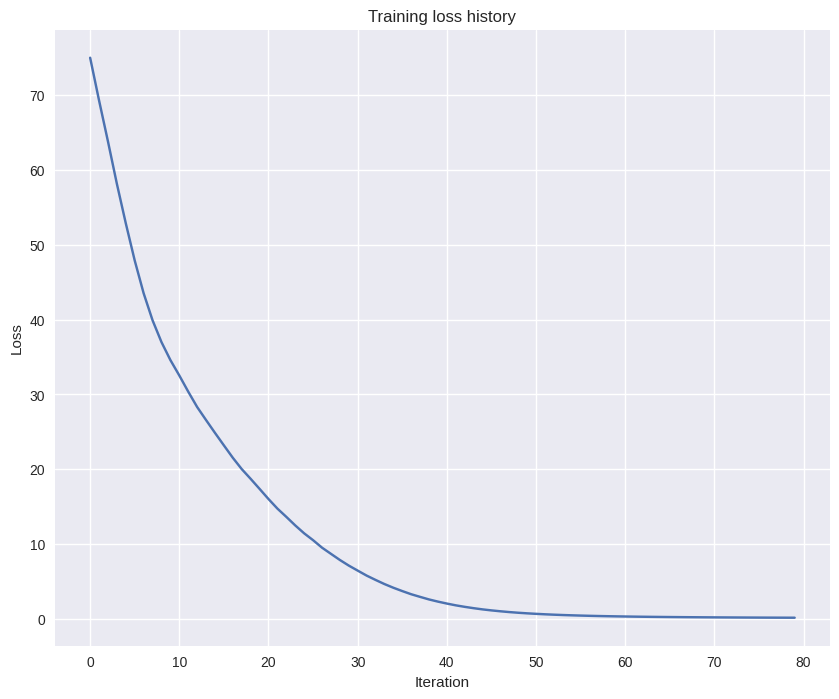

In [ ]:
from a5_helper import train_captioner

reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train - 1, steps=small_num_train).long()
small_image_data = data_dict["train_images"][sample_idx]
small_caption_data = data_dict["train_captions"][sample_idx]

# optimization arguments
num_epochs = 80

# create the image captioning model
model = CaptioningRNN(
    cell_type="rnn",
    word_to_idx=data_dict["vocab"]["token_to_idx"],
    input_dim=400,  # hard-coded, do not modify
    hidden_dim=512,
    wordvec_dim=256,
    ignore_index=NULL_index,
)
model = model.to(**to_float)

for learning_rate in [1e-3]:
    print("learning rate is: ", learning_rate)
    rnn_overfit, _ = train_captioner(
        model,
        small_image_data,
        small_caption_data,
        num_epochs=num_epochs,
        batch_size=OVR_BATCH_SIZE,
        learning_rate=learning_rate,
        device=DEVICE,
    )

## Inference: Sampling Captions

Unlike classification models, image captioning models behave very differently at training time and at test time.
At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep.
At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

Implement the `CaptioningRNN.sample` for test-time sampling. After doing so, run the following to train a captioning model and sample from the model on both training and validation data.

### Train the image captioning model

Now perform the training on the entire training set. You should see a final loss less than `2.0` and each epoch should take ~14s - 44s to run, depending on the GPU colab assigns you.

For input images in NCHW format, shape (2, 3, 224, 224)
Shape of output c5 features: torch.Size([2, 400, 7, 7])
learning rate is:  0.001
(Epoch 0 / 60) loss: 46.3335 time per epoch: 8.0s
(Epoch 1 / 60) loss: 39.9319 time per epoch: 7.9s
(Epoch 2 / 60) loss: 35.9900 time per epoch: 7.9s
(Epoch 3 / 60) loss: 32.9808 time per epoch: 8.0s
(Epoch 4 / 60) loss: 30.4050 time per epoch: 8.0s
(Epoch 5 / 60) loss: 28.1308 time per epoch: 8.1s
(Epoch 6 / 60) loss: 26.1264 time per epoch: 8.2s
(Epoch 7 / 60) loss: 24.4770 time per epoch: 8.2s
(Epoch 8 / 60) loss: 22.9255 time per epoch: 8.2s
(Epoch 9 / 60) loss: 21.7027 time per epoch: 8.3s
(Epoch 10 / 60) loss: 20.4075 time per epoch: 8.3s
(Epoch 11 / 60) loss: 18.9271 time per epoch: 8.4s
(Epoch 12 / 60) loss: 17.5797 time per epoch: 8.4s
(Epoch 13 / 60) loss: 16.4398 time per epoch: 8.4s
(Epoch 14 / 60) loss: 15.2633 time per epoch: 8.4s
(Epoch 15 / 60) loss: 14.5350 time per epoch: 8.4s
(Epoch 16 / 60) loss: 13.8894 time per epoch: 8.5s
(Epoch

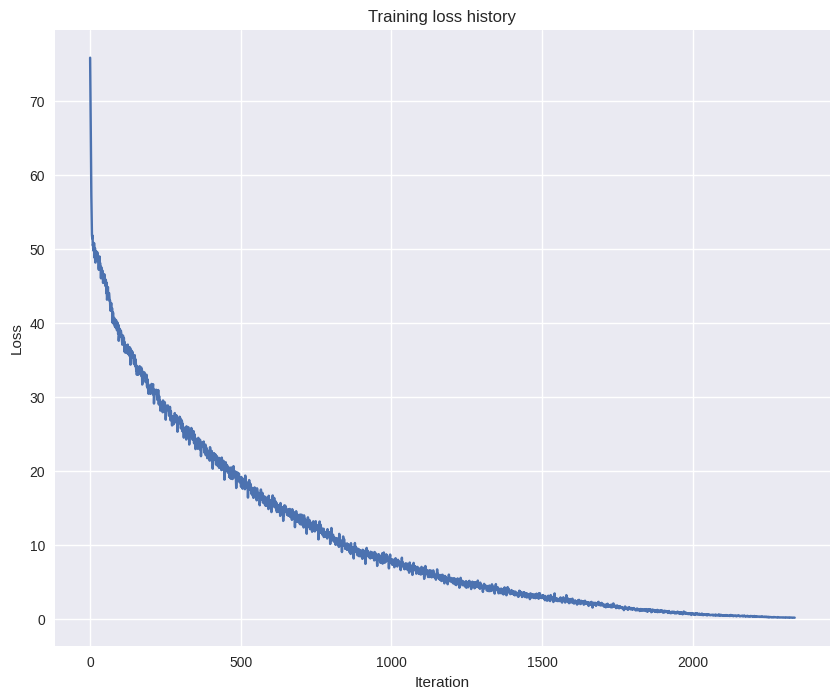

In [ ]:
from a5_helper import train_captioner

reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,))
small_image_data = data_dict["train_images"][sample_idx]
small_caption_data = data_dict["train_captions"][sample_idx]

# create the image captioning model
rnn_model = CaptioningRNN(
    cell_type="rnn",
    word_to_idx=data_dict["vocab"]["token_to_idx"],
    input_dim=400,  # hard-coded, do not modify
    hidden_dim=512,
    wordvec_dim=256,
    ignore_index=NULL_index,
)

for learning_rate in [1e-3]:
    print("learning rate is: ", learning_rate)
    rnn_model_submit, rnn_loss_submit = train_captioner(
        rnn_model,
        small_image_data,
        small_caption_data,
        num_epochs=60,
        batch_size=BATCH_SIZE,
        learning_rate=learning_rate,
        device=DEVICE,
    )

### Test-time sampling
The samples on training data should be very good; the samples on validation data will probably make less sense.

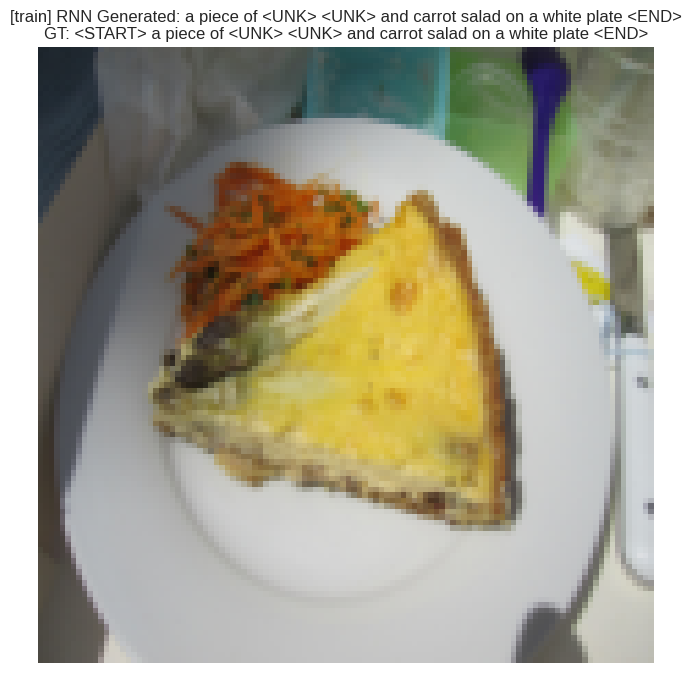

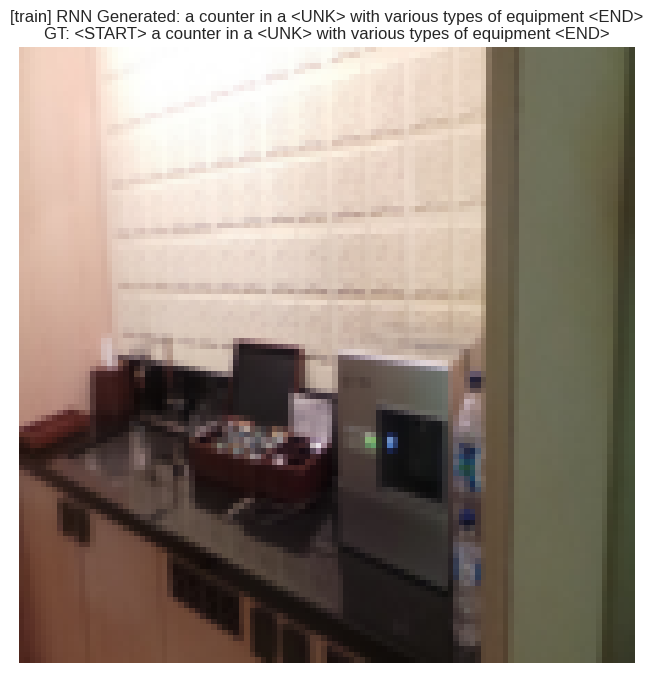

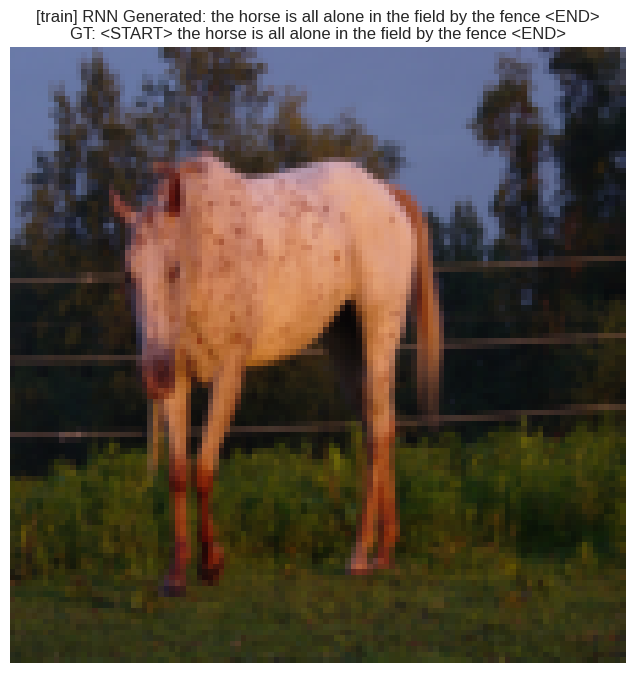

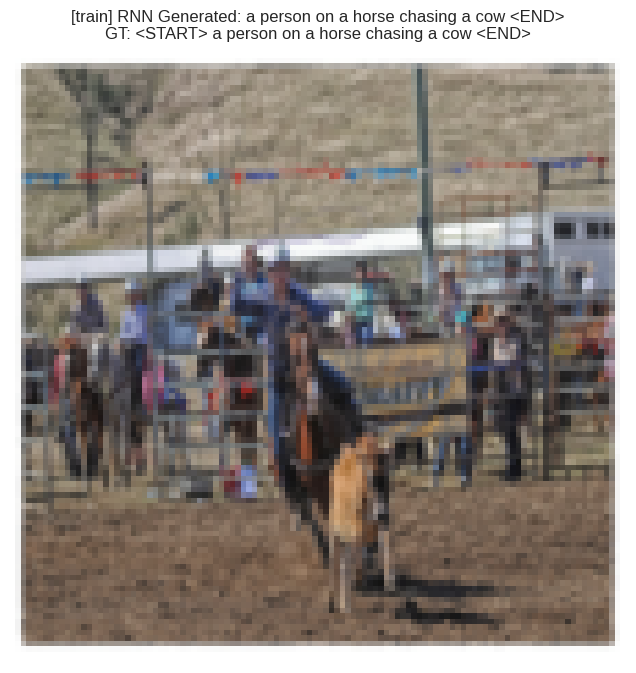

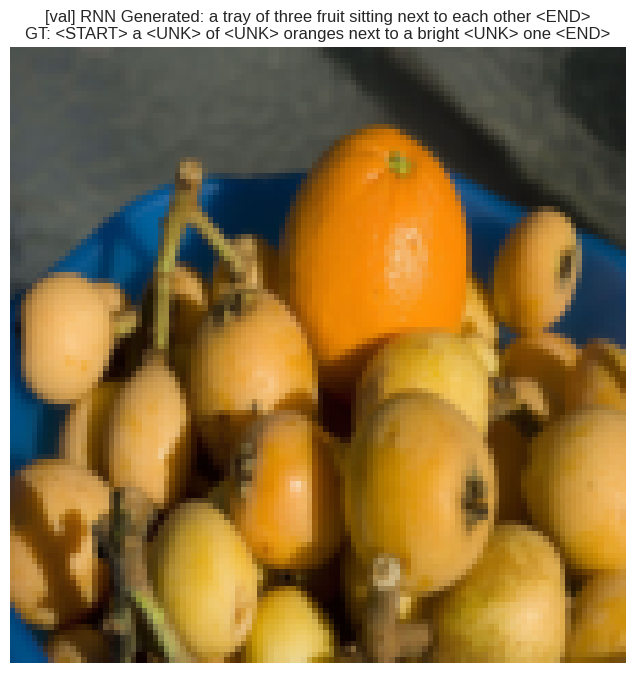

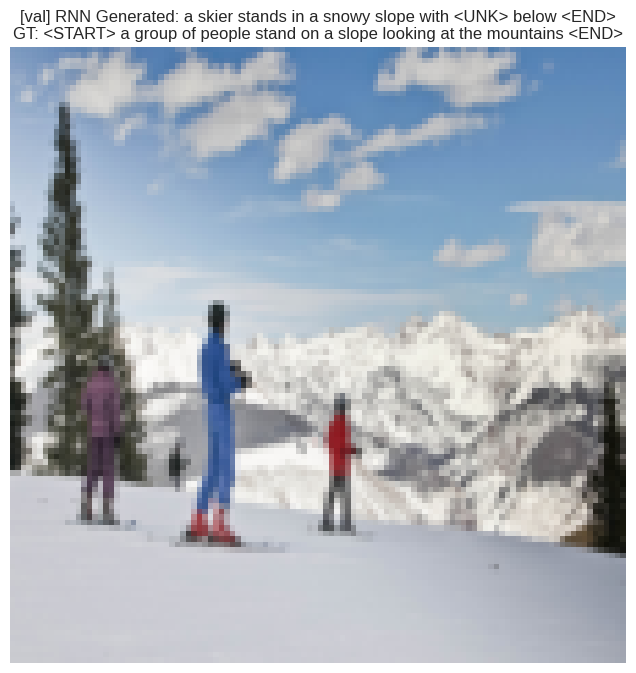

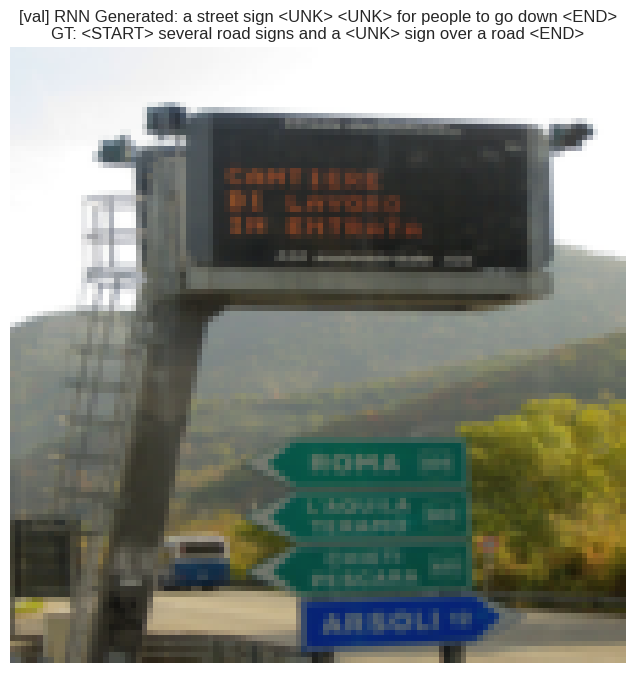

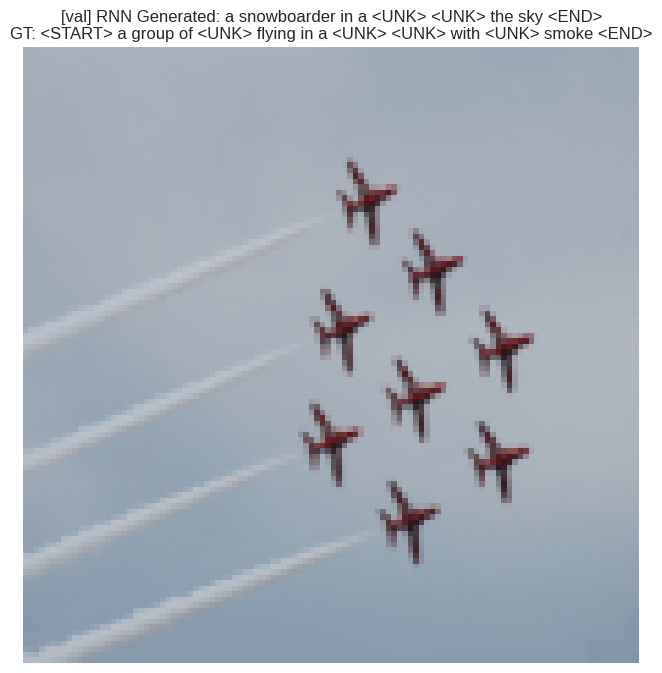

In [ ]:
from a5_helper import decode_captions


rnn_model.eval()

for split in ["train", "val"]:
    sample_idx = torch.randint(
        0, num_train if split == "train" else num_val, (VIS_BATCH_SIZE,)
    )
    sample_images = data_dict[split + "_images"][sample_idx]
    sample_captions = data_dict[split + "_captions"][sample_idx]

    # decode_captions is loaded from a5_helper.py
    gt_captions = decode_captions(sample_captions, data_dict["vocab"]["idx_to_token"])

    generated_captions = rnn_model.sample(sample_images.to(DEVICE))
    generated_captions = decode_captions(
        generated_captions, data_dict["vocab"]["idx_to_token"]
    )

    for i in range(VIS_BATCH_SIZE):
        plt.imshow(sample_images[i].permute(1, 2, 0))
        plt.axis("off")
        plt.title(
            f"[{split}] RNN Generated: {generated_captions[i]}\nGT: {gt_captions[i]}"
        )
        plt.show()